In [1]:
# import libraries
import numpy as np
import scipy
from math import pi as PI
from math import sqrt, sin, cos
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from scipy.optimize import minimize
%matplotlib inline

In [2]:
# GLOBAL VARIABLES:
compressive_stress_limit = -103421359 # Pa
tensile_stress_limit = 137895146 # Pa
displacement_limit = 0.00508 # m

density_of_material = 2768 # kg/m3
elastic_modulus = 68947572930 # Pa

L1 = sqrt(2) * 0.254 # m
L2 = 0.254 #m

In [3]:
def sign(n):
    if n > 0: return 1
    elif n == 0: return 0
    else: return -1

def element_stiffness_matrix(stiff, theta):
    coeff_matrix = np.array([
        
        [           cos(theta)**2,  cos(theta) * sin(theta),           -cos(theta)**2, -cos(theta) * sin(theta)],
        
        [ cos(theta) * sin(theta),            sin(theta)**2, -cos(theta) * sin(theta),           -sin(theta)**2],
        
        [          -cos(theta)**2, -cos(theta) * sin(theta),            cos(theta)**2,  cos(theta) * sin(theta)],
        
        [-cos(theta) * sin(theta),           -sin(theta)**2,  cos(theta) * sin(theta),            sin(theta)**2]])
    
    return stiff * coeff_matrix

def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

In [4]:
def FEM_model(A):
    A1, A2 = A
    compressive_stress_limit = -103421359 # Pa
    tensile_stress_limit = 137895146 # Pa
    displacement_limit = 0.00508 # m
    
    density_of_material = 2768 # kg/m3
    elastic_modulus = 68947572930 # Pa
    
#     A1 = 0.002 # m2
#     A2 = 0.002 # m2
    A3 = A1 # m2
    
    L1 = sqrt(2) * 0.254 # m
    L2 = 0.254 #m
    L3 = L1
    
    F1 = 88964 # m
    theta1 = -PI/4 # rad
    F1_x = F1 * cos(theta1)
    F1_y = F1 * sin(theta1)
    
    F2 = 88964 # m
    theta2 = -3*np.pi/4 # rad
    F2_x = F2 * cos(theta2)
    F2_y = F2 * sin(theta2)
    
    ele1_theta = 3 * PI /4
    ele2_theta = 2 * PI /4
    ele3_theta = 1 * PI /4

    ele1_EA_L =  elastic_modulus * A1 / L1
    ele2_EA_L =  elastic_modulus * A2 / L2
    ele3_EA_L =  elastic_modulus * A3 / L3
    
    ele1_stiffness_matrix = element_stiffness_matrix(ele1_EA_L, ele1_theta)
    ele2_stiffness_matrix = element_stiffness_matrix(ele2_EA_L, ele2_theta)
    ele3_stiffness_matrix = element_stiffness_matrix(ele3_EA_L, ele3_theta)
    
    
    
    # GLOBAL MATRIX
    global_stiff_matrix = np.zeros((4*2, 4*2))
    
    ele_1_to_global_stiff_matrix = np.zeros((4*2, 4*2))
    ele_2_to_global_stiff_matrix = np.zeros((4*2, 4*2))
    ele_3_to_global_stiff_matrix = np.zeros((4*2, 4*2))

    ele_1_to_global_stiff_matrix[0, [0, 1, 6, 7]] = ele1_stiffness_matrix[0]
    ele_1_to_global_stiff_matrix[1, [0, 1, 6, 7]] = ele1_stiffness_matrix[1]
    ele_1_to_global_stiff_matrix[6, [0, 1, 6, 7]] = ele1_stiffness_matrix[2]
    ele_1_to_global_stiff_matrix[7, [0, 1, 6, 7]] = ele1_stiffness_matrix[3]

    ele_2_to_global_stiff_matrix[2, [2, 3, 6, 7]] = ele2_stiffness_matrix[0]
    ele_2_to_global_stiff_matrix[3, [2, 3, 6, 7]] = ele2_stiffness_matrix[1]
    ele_2_to_global_stiff_matrix[6, [2, 3, 6, 7]] = ele2_stiffness_matrix[2]
    ele_2_to_global_stiff_matrix[7, [2, 3, 6, 7]] = ele2_stiffness_matrix[3]

    ele_3_to_global_stiff_matrix[4, [4, 5, 6, 7]] = ele3_stiffness_matrix[0]
    ele_3_to_global_stiff_matrix[5, [4, 5, 6, 7]] = ele3_stiffness_matrix[1]
    ele_3_to_global_stiff_matrix[6, [4, 5, 6, 7]] = ele3_stiffness_matrix[2]
    ele_3_to_global_stiff_matrix[7, [4, 5, 6, 7]] = ele3_stiffness_matrix[3]

    global_matrix = ele_1_to_global_stiff_matrix + ele_2_to_global_stiff_matrix + ele_3_to_global_stiff_matrix
    
    # BC
    u1_x = 0
    u1_y = 0

    u2_x = 0
    u2_y = 0

    u3_x = 0
    u3_y = 0
    u = np.zeros(8)
    u[0:6] = [u1_x, u1_y, u2_x, u2_y, u2_x, u2_y]
    
    # CASE 1
    u4_x = F1_x / global_matrix[6, 6]
    u4_y = F1_y / global_matrix[7, 7]
    u4_total_1 = sqrt(u4_x **2 + u4_y**2)

    u[6] = u4_x
    u[7] = u4_y

    forces = np.matmul(global_matrix, u)

    F_A = sign(forces[1])*sqrt(forces[0]**2 + forces[1]**2)
    F_B = sign(forces[3])*sqrt(forces[2]**2 + forces[3]**2)
    F_C = sign(forces[5])*sqrt(forces[4]**2 + forces[5]**2)

    stress_A_1 = F_A / A1
    stress_B_1 = F_B / A2
    stress_C_1 = F_C / A3

    # CASE 2
    u4_x = F2_x / global_matrix[6, 6]
    u4_y = F2_y / global_matrix[7, 7]
    u4_total_2 = sqrt(u4_x **2 + u4_y**2)

    u[6] = u4_x
    u[7] = u4_y

    forces = np.matmul(global_matrix, u)

    F_A = sign(forces[1])*sqrt(forces[0]**2 + forces[1]**2)
    F_B = sign(forces[3])*sqrt(forces[2]**2 + forces[3]**2)
    F_C = sign(forces[5])*sqrt(forces[4]**2 + forces[5]**2)

    stress_A_2 = F_A / A1
    stress_B_2 = F_B / A2
    stress_C_2 = F_C / A3
    
    max_stress_in_bar_from_both_case = np.array([
        max(stress_A_1, stress_A_2),
        max(stress_B_1, stress_B_2),
        max(stress_C_1, stress_C_2)
    ])
    
    min_stress_in_bar_from_both_case = np.array([
        min(stress_A_1, stress_A_2),
        min(stress_B_1, stress_B_2),
        min(stress_C_1, stress_C_2)
    ])
    
    max_total_deflection = max(u4_total_1, u4_total_2)  
    
    return np.array([
                     tensile_stress_limit - max(max_stress_in_bar_from_both_case),
                     min(min_stress_in_bar_from_both_case) - compressive_stress_limit,
                     displacement_limit - max_total_deflection])

## optimization

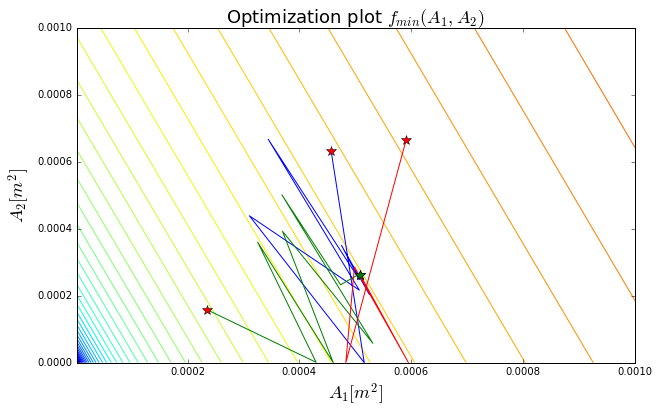

2/3 analysis solved
(A1 = 4.567E-04 [m2], A2 = 6.336E-04   [m2]) - solved: True 
(A1 = 2.352E-04 [m2], A2 = 1.583E-04   [m2]) - solved: True 
(A1 = 5.912E-04 [m2], A2 = 6.659E-04   [m2]) - solved: False
red star - start point
green star - end point


In [5]:
number_of_start_point = 3
plot_optimizaiton_path = True

param_max = 1e-3 # maximal value of start point;

x_start_points = param_max * np.random.rand(number_of_start_point, 2)

### DEFINE START POINT IN EXPLICITE WAY: ###
# x_start_points = [[1e-4, 8e-4], [8e-4, 8e-4], [8e-4, 1e-4], [2e-3, 2e-3]] 

paths = []

converged = np.zeros(number_of_start_point)

i = 0
for x0 in x_start_points:
    obj_fun = lambda x: density_of_material * (2 * L1 * x[0] + L2 * x[1])

    cons = ({'type': 'ineq', 'fun': FEM_model})
    bnds = ((1e-6, 1e-1), (1e-6, 1e-1))

    path_ = [x0]
    
# type of method
    res = minimize(obj_fun, x0,  method='SLSQP', constraints=cons, bounds=bnds, options={'maxiter':100, 'ftol': 1e-6},
                   callback=make_minimize_cb(path_))
    converged[i] = res.success
    paths.append(path_)
    i += 1

xmin, xmax, xstep = 1e-6, param_max, param_max/1e2
ymin, ymax, ystep = 1e-6, param_max, param_max/1e2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

z = obj_fun([x, y])

fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(-2, 1, 50), norm=LogNorm(), cmap=plt.cm.jet)

for path in paths:
    iter_x = []
    iter_y = []
    for i in path:
        iter_x.append(i[0])
        iter_y.append(i[1])
  

    if plot_optimizaiton_path: ax.plot(iter_x,iter_y)
    ax.plot(iter_x[0],iter_y[0], '*', markersize = 10, color = 'red')
    ax.plot(iter_x[-1],iter_y[-1], '*', markersize = 10, color = 'green')

ax.set_xlabel('$A_1 [m^2]$', size=18)
ax.set_ylabel('$A_2 [m^2]$', size=18)

if xmax > 1e-3:
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))
else:
    ax.set_xlim((xmin, 1e-3))
    ax.set_ylim((ymin, 1e-3))
ax.set_title('Optimization plot $f_{min}(A_1, A_2)$', size = 18)
plt.show()
print('{}/{} analysis solved'.format(int(converged.sum()), len(converged)))
i = 0
for start_point in x_start_points:
    print('(A1 = {:.3E} [m2], A2 = {:.3E}   [m2]) - solved: {:5s}'.format(start_point[0], start_point[1], str(bool(converged[i]))))
    i += 1
    
print('red star - start point')
print('green star - end point')

In [6]:
print('Solution:')
print('A1 = {:.4f} mm\nA2 = {:.4f} mm'.format(*1000*res.x))
print('mass = {:.4f} kg'.format(obj_fun(res.x)))
print()
print('Constrains:')
print('{:15s}|{:^15s}|{:^15s}|{:^15s}|'.format('', 'Max [MPa]', 'Limit [MPa]', 'Usage [%]'))
print(64*'-')
print('{:^15s}|{:^15s}|{:^15s}|{:^15s}|'.format(
        'Tensile', 
        '{:.3f}'.format(-(FEM_model(res.x)[0]-tensile_stress_limit)/1e6), 
        '{:.3f}'.format(tensile_stress_limit/1e6), 
        '{:.3f}'.format(100*-(FEM_model(res.x)[0]-tensile_stress_limit)/tensile_stress_limit)))
print(64*'-')
print('{:^15s}|{:^15s}|{:^15s}|{:^15s}|'.format(
        'Compressive', 
        '{:.3f}'.format((FEM_model(res.x)[1]+compressive_stress_limit)/1e6), 
        '{:.3f}'.format(compressive_stress_limit/1e6), 
        '{:.3f}'.format(100*(FEM_model(res.x)[1]+compressive_stress_limit)/compressive_stress_limit)))
print(64*'-')
print()
print()
print('{:15s}|{:^15s}|{:^15s}|{:^15s}|'.format('', 'Max [mm]', 'Limit [mm]', 'Usage [%]'))
print(64*'-')
print('{:^15s}|{:^15s}|{:^15s}|{:^15s}|'.format(
        'Deflection', 
        '{:.3f}'.format(-(FEM_model(res.x)[2]-displacement_limit)*1e3), 
        '{:.3f}'.format(displacement_limit*1e3), 
        '{:.3f}'.format(100*-(FEM_model(res.x)[2]-displacement_limit)/displacement_limit)))
print(64*'-')


Solution:
A1 = 0.5088 mm
A2 = 0.2634 mm
mass = 1.1970 kg

Constrains:
               |   Max [MPa]   |  Limit [MPa]  |   Usage [%]   |
----------------------------------------------------------------
    Tensile    |    137.895    |    137.895    |    100.000    |
----------------------------------------------------------------
  Compressive  |    -36.949    |   -103.421    |    35.727     |
----------------------------------------------------------------


               |   Max [mm]    |  Limit [mm]   |   Usage [%]   |
----------------------------------------------------------------
  Deflection   |     0.744     |     5.080     |    14.641     |
----------------------------------------------------------------
